In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# CICDDoS2019

## Processamento 

### Downsample 

In [57]:
def processar_e_salvar_dia(
        dia, 
        dataset_path, 
        chunk_size, 
        cols_to_drop, 
        attack_order, 
        output_files, 
        ATTACK_LABEL_COL,
        BENIGN_LABEL,
        DOWNSAMPLE_FACTORS,
        MIN_SAMPLES_PER_CHUNK
    ):
    
    lista_arquivos = attack_order[dia]
    output_filepath = output_files[dia]
    total_amostras_mantidas = 0
    header_escrito = False

    LABEL_COL_LIMPA = ATTACK_LABEL_COL.strip() 
    COLS_DROP_LIMPA = [c.strip() for c in cols_to_drop]

    with open(output_filepath, 'w', newline='', encoding='utf-8') as f:
        
        for filename in lista_arquivos:
            filepath = os.path.join(dataset_path, dia, filename)
            attack_name_from_file = filename.replace('.csv', '')
            
            try:
                csv_reader = pd.read_csv(
                    filepath, 
                    chunksize=chunk_size, 
                    low_memory=False, 
                    on_bad_lines='skip'
                )
            except Exception:
                continue
                
            for df_chunk in csv_reader:
                
                # Remove espaços das colunas do DATAFRAME (O que você já fez)
                df_chunk.columns = df_chunk.columns.str.strip()
                
                # Limpeza de Colunas (Usando a lista limpa)
                cols_existentes_drop = [col for col in COLS_DROP_LIMPA if col in df_chunk.columns]
                df_chunk = df_chunk.drop(columns=cols_existentes_drop, errors='ignore')
                
                # Normalização do Rótulo
                if LABEL_COL_LIMPA in df_chunk.columns:
                    df_chunk[LABEL_COL_LIMPA] = df_chunk[LABEL_COL_LIMPA].apply(
                        lambda x: BENIGN_LABEL if 'BENIGN' in str(x).upper() else attack_name_from_file
                    )
                else:
                    # Se não achar a coluna Label mesmo após limpar, pula
                    continue
                
                # Usa a variável limpa para filtrar
                df_benign = df_chunk[df_chunk[LABEL_COL_LIMPA] == BENIGN_LABEL]
                df_ataque = df_chunk[df_chunk[LABEL_COL_LIMPA] != BENIGN_LABEL]

                if not df_ataque.empty:
                    factor = DOWNSAMPLE_FACTORS.get(attack_name_from_file, DOWNSAMPLE_FACTORS['Default'])
                    
                    if len(df_ataque) < MIN_SAMPLES_PER_CHUNK:
                        factor = 1.0
                    
                    if factor < 1.0:
                        df_ataque = df_ataque.sample(frac=factor, random_state=42)

                # Combina e Restaura a Ordem pelo Índice
                df_chunk_reduzido = pd.concat([df_benign, df_ataque])
                df_chunk_reduzido = df_chunk_reduzido.sort_index()
                
                if df_chunk_reduzido.empty:
                    continue

                # Salvamento
                df_chunk_reduzido.to_csv(
                    f, 
                    index=False, 
                    header=not header_escrito, 
                    mode='a' 
                )
                header_escrito = True
                total_amostras_mantidas += len(df_chunk_reduzido)

    return total_amostras_mantidas

In [ ]:
DATASET_PATH = 'datasets/CICDDoS2019/'
PANDAS_CHUNK_SIZE = 100000 
ATTACK_LABEL_COL = ' Label' 
COLUMNS_TO_DROP = ['Unnamed: 0', 'Flow ID', 'SimillarHTTP']
MIN_SAMPLES_PER_CHUNK = 1000
BENIGN_LABEL = 'BENIGN'

# Simula o REAL
# DOWNSAMPLE_FACTORS = {
#     'BENIGN': 1.0,           
#     'WebDDoS': 1.0,          
#     'TFTP': 0.0002,          
#     'DrDoS_DNS': 0.001,      
#     'DrDoS_LDAP': 0.001,
#     'DrDoS_MSSQL': 0.001,
#     'DrDoS_NTP': 0.001,
#     'DrDoS_NetBIOS': 0.001,
#     'DrDoS_SNMP': 0.001,
#     'DrDoS_SSDP': 0.001,
#     'DrDoS_UDP': 0.001,
#     'LDAP': 0.001,            
#     'MSSQL': 0.001,
#     'NetBIOS': 0.001,
#     'UDP': 0.001,
#     'Syn': 0.0015,            
#     'UDPLag': 0.005,           
#     'Portmap': 0.01,          
#     'Default': 0.001          
# }

# A Classe Ataques Majoritária
# DOWNSAMPLE_FACTORS = {
#     'WebDDoS': 1.0,          
#     'TFTP': 0.001,           
#     # Reflexão Massiva
#     'DrDoS_DNS': 0.01,       
#     'DrDoS_LDAP': 0.01,
#     'DrDoS_MSSQL': 0.01,
#     'DrDoS_NTP': 0.01,
#     'DrDoS_NetBIOS': 0.01,
#     'DrDoS_SNMP': 0.01,
#     'DrDoS_SSDP': 0.01,
#     'DrDoS_UDP': 0.01,
#     # FAMÍLIA EXPLORAÇÃO/REFLEXÃO 
#     'LDAP': 0.01,            
#     'MSSQL': 0.01,
#     'NetBIOS': 0.01,
#     'UDP': 0.01,
#     # FAMÍLIA TÁTICA 
#     'Syn': 0.05,             
#     'Portmap': 0.1,          
#     'UDPLag': 0.2,           
#     'Default': 0.01          
# }


# A concatenação dos 2 dias fica balanceado (Grande)
DOWNSAMPLE_FACTORS = {
    'WebDDoS': 1.0,          
    'Syn': 0.021,             
    'UDPLag': 0.11,           
    'TFTP': 0.006,           
    'DrDoS_SNMP': 0.022,      
    'DrDoS_DNS': 0.023,       
    'DrDoS_MSSQL': 0.026,     
    'DrDoS_NetBIOS': 0.029,   
    'DrDoS_UDP': 0.037,       
    'DrDoS_SSDP': 0.045,      
    'DrDoS_LDAP': 0.053,      
    'DrDoS_NTP': 0.095,       
    'MSSQL': 0.021,           
    'NetBIOS': 0.034,         
    'UDP': 0.031,             
    'LDAP': 0.055,            
    'Portmap': 0.65,          
    'Default': 0.02           
}

ATTACK_ORDER = {
    '03-11': [
        'Portmap.csv', 'NetBIOS.csv', 'LDAP.csv', 'MSSQL.csv', 'UDP.csv', 'UDPLag.csv', 'Syn.csv'
    ],
    '01-12': [
        'DrDoS_NTP.csv', 'DrDoS_DNS.csv', 'DrDoS_LDAP.csv', 'DrDoS_MSSQL.csv', 'DrDoS_NetBIOS.csv', 'DrDoS_SNMP.csv', 'DrDoS_SSDP.csv', 'DrDoS_UDP.csv', 
        'UDPLag.csv', 'Syn.csv', 'TFTP.csv' 
    ]
}

OUTPUT_FILES = {
    '03-11': 'CICDDoS2019_03_11.csv',
    '01-12': 'CICDDoS2019_01_12.csv'
}

dia_0311 = processar_e_salvar_dia(
    dia='03-11', 
    dataset_path=DATASET_PATH,
    chunk_size=PANDAS_CHUNK_SIZE,
    cols_to_drop=COLUMNS_TO_DROP,
    attack_order=ATTACK_ORDER,
    output_files=OUTPUT_FILES,
    ATTACK_LABEL_COL=ATTACK_LABEL_COL,
    BENIGN_LABEL=BENIGN_LABEL,
    DOWNSAMPLE_FACTORS=DOWNSAMPLE_FACTORS,
    MIN_SAMPLES_PER_CHUNK=MIN_SAMPLES_PER_CHUNK
)
print(f"Dataset salvo: {OUTPUT_FILES['03-11']} (Total: {dia_0311:,} amostras)")

dia_0112 = processar_e_salvar_dia(
    dia='01-12', 
    dataset_path=DATASET_PATH,
    chunk_size=PANDAS_CHUNK_SIZE,
    cols_to_drop=COLUMNS_TO_DROP,
    attack_order=ATTACK_ORDER,
    output_files=OUTPUT_FILES,
    ATTACK_LABEL_COL=ATTACK_LABEL_COL,
    BENIGN_LABEL=BENIGN_LABEL,
    DOWNSAMPLE_FACTORS=DOWNSAMPLE_FACTORS,
    MIN_SAMPLES_PER_CHUNK=MIN_SAMPLES_PER_CHUNK
)
print(f"Dataset salvo: {OUTPUT_FILES['01-12']} (Total: {dia_0112:,} amostras)")

Dataset salvo: CICDDoS2019_03_11.csv (Total: 819,585 amostras)
Dataset salvo: CICDDoS2019_01_12.csv (Total: 1,180,678 amostras)


### Verificação da Base de dados gerada

Label
TFTP             120511
DrDoS_NetBIOS    118710
DrDoS_MSSQL      117590
DrDoS_SSDP       117479
DrDoS_DNS        116641
DrDoS_UDP        115985
DrDoS_LDAP       115536
DrDoS_NTP        114251
DrDoS_SNMP       113522
BENIGN            56863
UDPLag            40359
Syn               33231
Name: count, dtype: int64


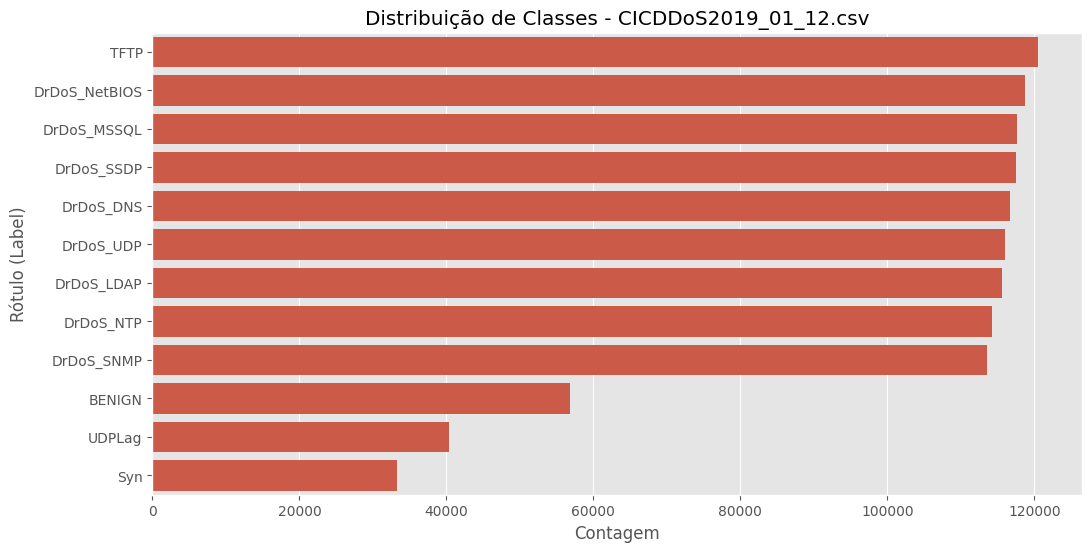

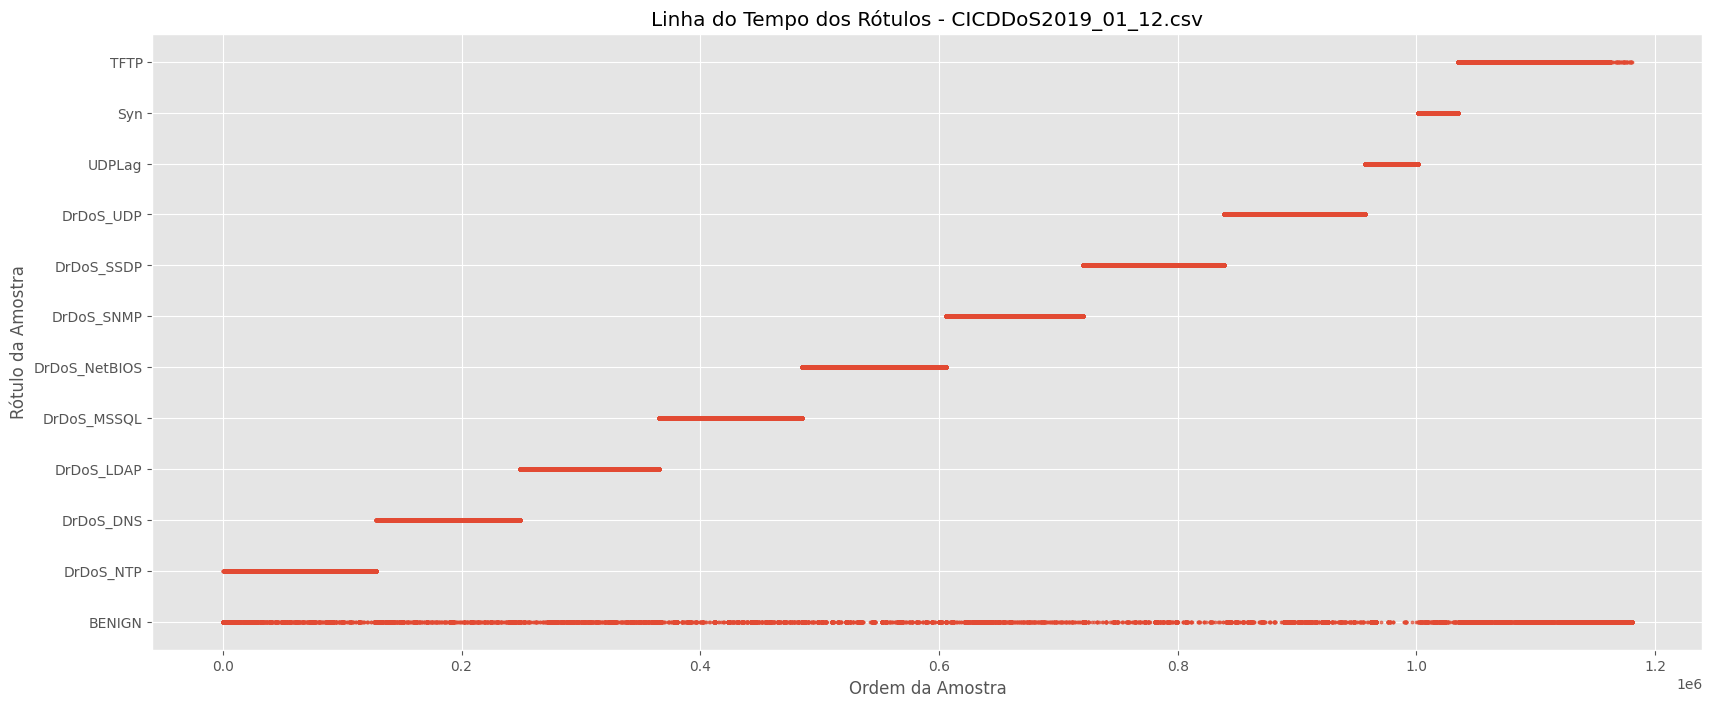

In [71]:
# --- Análise Exploratória do Dataset  ---
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 7) 
plt.style.use('ggplot') 

# --- Carregar o Dataset de Teste ---
# file = 'datasets\CICDDoS2019\CICDDoS2019_03_11.csv'
# file = 'datasets\CICDDoS2019\CICDDoS2019_01_12.csv'
file = 'CICDDoS2019_01_12.csv'

df = pd.read_csv(file)

# --- Contagem de Rótulos ---
print(df['Label'].value_counts())

# --- Gráfico de Contagem de Rótulos ---
plt.figure(figsize=(12, 6))
sns.countplot(y=df['Label'], order=df['Label'].value_counts().index)
plt.title(f'Distribuição de Classes - {file}')
plt.xlabel('Contagem')
plt.ylabel('Rótulo (Label)')
plt.show()

# Ordenar o DataFrame pelo Timestamp e plotar o gráfico da linha do tempo
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df_sorted = df.sort_values(by='Timestamp')

# Resetar o index para que o eixo X do gráfico seja a ordem da amostra
df_sorted = df_sorted.reset_index(drop=True)

# --- Gráfico da Ordem dos Rótulos ---
plt.figure(figsize=(20, 8))
plt.scatter(df_sorted.index, df_sorted['Label'], s=5, alpha=0.7)
plt.title(f'Linha do Tempo dos Rótulos - {file}')
plt.xlabel('Ordem da Amostra')
plt.ylabel('Rótulo da Amostra')
plt.show()

## Análise dos Ataques

### Dicionário de Features do CIC-DDoS2019

**Identificadores de Fluxo**
* **Source IP**: Endereço IP de Origem - O IP que iniciou a conexão ou enviou o pacote.
* **Source Port**: Porta de Origem - A porta lógica utilizada pelo remetente.
* **Destination IP**: Endereço IP de Destino - O IP alvo para onde o pacote foi enviado.
* **Destination Port**: Porta de Destino - A porta lógica alvo no destinatário.
* **Protocol**: Protocolo - Identificador numérico do protocolo de transporte (ex: 6 para TCP, 17 para UDP).
* **Timestamp**: Carimbo de Tempo - A data e hora exata em que o fluxo iniciou.
* **Flow Duration**: Duração do Fluxo - O tempo total de duração da conexão ou fluxo.

**Volumetria e Contagem**
* **Total Fwd Packets**: Total de Pacotes de Ida - Quantidade total de pacotes enviados na direção origem-destino.
* **Total Backward Packets**: Total de Pacotes de Volta - Quantidade total de pacotes enviados na direção destino-origem.
* **Total Length of Fwd Packets**: Comprimento Total (Ida) - Soma total de bytes dos pacotes enviados na direção de ida.
* **Total Length of Bwd Packets**: Comprimento Total (Volta) - Soma total de bytes dos pacotes enviados na direção de volta.
* **Fwd Packet Length Max/Min/Mean/Std**: Estatísticas de Comprimento (Ida) - Máximo, mínimo, média e desvio padrão do tamanho dos pacotes de ida.
* **Bwd Packet Length Max/Min/Mean/Std**: Estatísticas de Comprimento (Volta) - Máximo, mínimo, média e desvio padrão do tamanho dos pacotes de volta.
* **Flow Bytes/s**: Fluxo de Bytes por Segundo - A taxa de transferência de dados (throughput) do fluxo.
* **Flow Packets/s**: Fluxo de Pacotes por Segundo - A intensidade de pacotes trafegados no fluxo.

**Tempo entre Chegadas (IAT - Inter-Arrival Time)**
* **Flow IAT Mean/Std/Max/Min**: IAT do Fluxo - Estatísticas do tempo de intervalo entre dois pacotes consecutivos no fluxo geral.
* **Fwd IAT Total/Mean/Std/Max/Min**: IAT de Ida - Estatísticas do tempo de intervalo entre pacotes consecutivos apenas na direção de ida.
* **Bwd IAT Total/Mean/Std/Max/Min**: IAT de Volta - Estatísticas do tempo de intervalo entre pacotes consecutivos apenas na direção de volta.

**Flags e Cabeçalhos (Comportamento TCP)**
* **Fwd/Bwd PSH Flags**: Flags Push - Indica se a flag PSH (enviar dados imediatamente) foi usada na ida ou volta.
* **Fwd/Bwd URG Flags**: Flags Urgent - Indica se a flag URG (dados prioritários) foi usada na ida ou volta.
* **Fwd/Bwd Header Length**: Tamanho do Cabeçalho - Total de bytes usados apenas pelos cabeçalhos dos pacotes na ida ou volta.
* **Fwd/Bwd Packets/s**: Taxa de Pacotes por Direção - Quantidade de pacotes por segundo calculada separadamente para ida e volta.
* **Min/Max Packet Length**: Comprimento Mínimo/Máximo - O menor e o maior pacote observado em todo o fluxo.
* **Packet Length Mean/Std/Variance**: Estatísticas Globais de Tamanho - Média, desvio padrão e variância do tamanho dos pacotes do fluxo inteiro.
* **FIN/SYN/RST/PSH/ACK/URG/CWE/ECE Flag Count**: Contagem de Flags - Número de vezes que cada flag de controle TCP específica apareceu no fluxo.

**Segmentação e Subfluxos**
* **Down/Up Ratio**: Razão Download/Upload - A proporção entre o tráfego de descida e subida.
* **Average Packet Size**: Tamanho Médio do Pacote - A média geral do tamanho dos pacotes trafegados.
* **Avg Fwd/Bwd Segment Size**: Tamanho Médio do Segmento - Média do tamanho dos segmentos de dados (payload) na ida e na volta.
* **Fwd/Bwd Avg Bytes/Packets/Bulk Rate**: Taxas de Transferência em Bloco - Métricas médias para transferências contínuas (bulk) na ida e volta.
* **Subflow Fwd/Bwd Packets/Bytes**: Subfluxos - Média de pacotes ou bytes agrupados por subfluxos lógicos.

**Janelas e Atividade (TCP Windows & Timers)**
* **Init_Win_bytes_forward**: Janela Inicial de Ida - Tamanho da janela de recepção TCP (buffer) inicial enviada pela origem.
* **Init_Win_bytes_backward**: Janela Inicial de Volta - Tamanho da janela de recepção TCP inicial enviada pelo destino.
* **act_data_pkt_fwd**: Pacotes de Dados Ativos - Contagem de pacotes na direção de ida que realmente continham dados (payload).
* **min_seg_size_forward**: Tamanho Mínimo do Segmento - O menor tamanho de segmento observado na direção de ida.
* **Active Mean/Std/Max/Min**: Tempo Ativo - Estatísticas do tempo que o fluxo permaneceu ativo antes de entrar em ociosidade.
* **Idle Mean/Std/Max/Min**: Tempo Ocioso - Estatísticas do tempo que o fluxo permaneceu parado (idle) antes de retomar atividade.

**Rótulos**
* **Inbound**: Direção do Tráfego - Indica se o tráfego é de entrada (geralmente 1 para ataque ao servidor) ou saída.
* **Label**: Rótulo - A classificação final do fluxo (ex: Benign, DrDoS_LDAP, Syn, etc.).

### Funções

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from math import pi, ceil
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform

def carregar_e_unificar(lista_arquivos, CHUNK_SIZE):
    cols_to_ignore = [
        'Flow ID', 'Source IP', 'Source Port', 'Destination IP', 
        'Destination Port', 'Timestamp', 'SimillarHTTP', 'Unnamed: 0'
    ]
    
    df_list = []
    print(f"Iniciando processamento integral de {len(lista_arquivos)} arquivos...")
    
    for filepath in lista_arquivos:
        if not os.path.exists(filepath):
            continue
            
        nome_arquivo = os.path.basename(filepath)
        print(f"--> Lendo: {nome_arquivo}")
        
        try:
            with pd.read_csv(filepath, chunksize=CHUNK_SIZE, low_memory=False) as reader:
                for chunk in reader:
                    chunk.columns = chunk.columns.str.strip()
                    chunk = chunk.drop(columns=[c for c in cols_to_ignore if c in chunk.columns], errors='ignore')
                    chunk = chunk.dropna(axis=1, how='all')
                    chunk['Origem_Arquivo'] = nome_arquivo
                    df_list.append(chunk)
        except Exception as e:
            print(f"Erro crítico no arquivo {nome_arquivo}: {e}")

    if not df_list:
        return None
        
    df_final = pd.concat(df_list, ignore_index=True)
    df_final = df_final.replace([np.inf, -np.inf], np.nan)
    
    cols_numericas = df_final.select_dtypes(include=[np.number]).columns
    df_final[cols_numericas] = df_final[cols_numericas].fillna(df_final[cols_numericas].median())
    
    print(f"Dataset Unificado Pronto: {df_final.shape[0]} linhas.")
    return df_final

def remover_colunas_correlacionadas(df, limiar):
    print(f"Iniciando análise de correlação (Limiar: {limiar})...")
    df_numerico = df.select_dtypes(include=[np.number])
    matriz_corr = df_numerico.corr(method='pearson').abs()
    upper = matriz_corr.where(np.triu(np.ones(matriz_corr.shape), k=1).astype(bool))
    colunas_para_remover = [column for column in upper.columns if any(upper[column] > limiar)]
    print(f"Removendo {len(colunas_para_remover)} colunas redundantes.")
    return df.drop(columns=colunas_para_remover)

def identificar_features_importantes(df, top_n=10):
    X = df.select_dtypes(include=[np.number]).fillna(0)
    y = df['Label']
    
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    
    rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
    rf.fit(X, y_encoded)
    
    importances = rf.feature_importances_
    indices = np.argsort(importances)[::-1]
    melhores_features = [X.columns[i] for i in indices[:top_n]]
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x=importances[indices[:top_n]], y=melhores_features, hue=melhores_features, legend=False, palette='viridis')
    plt.title('Top Features Distintivas entre Ataques')
    plt.xlabel('Importância (Gini)')
    plt.tight_layout()
    plt.show()
    
    return melhores_features

def visualizar_radares_separados_referencia(df, features):
    df_grouped = df.groupby('Label')[features].mean()
    scaler = MinMaxScaler()
    df_norm = pd.DataFrame(scaler.fit_transform(df_grouped), columns=features, index=df_grouped.index)
    
    try:
        df_benign = df_norm.loc[['BENIGN']]
        df_attacks = df_norm.drop('BENIGN')
    except KeyError:
        df_benign = None
        df_attacks = df_norm

    num_vars = len(features)
    angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
    angles += angles[:1] 

    if df_benign is not None:
        plt.figure(figsize=(5, 5))
        ax = plt.subplot(111, polar=True)
        values = df_benign.iloc[0].tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=2, color='green', linestyle='solid')
        ax.fill(angles, values, color='green', alpha=0.2)
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(features, size=8, weight='bold', color='darkgreen')
        ax.tick_params(axis='x', pad=30)
        ax.set_ylim(0, 1)
        ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
        ax.set_yticklabels(["20%", "40%", "60%", "80%", "100%"], color="grey", size=10)
        plt.show()

    if not df_attacks.empty:
        labels_ataques = df_attacks.index
        num_ataques = len(labels_ataques)
        cols = 4
        rows = ceil(num_ataques / cols)
        
        fig, axes = plt.subplots(rows, cols, subplot_kw=dict(polar=True), figsize=(20, 5 * rows))
        axes_flat = axes.flatten()
        colors = plt.cm.magma(np.linspace(0.2, 0.9, num_ataques))

        for i, ataque in enumerate(labels_ataques):
            ax = axes_flat[i]
            values = df_attacks.loc[ataque].tolist()
            values += values[:1]
            ax.plot(angles, values, linewidth=2, color=colors[i])
            ax.fill(angles, values, color=colors[i], alpha=0.5)
            ax.set_xticks(angles[:-1])
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_ylim(0, 1)
            ax.grid(True, color='grey', linestyle=':', alpha=0.5)
            ax.set_title(ataque, size=14, weight='bold', y=1.05)

        for i in range(num_ataques, len(axes_flat)):
            fig.delaxes(axes_flat[i])

        plt.tight_layout()
        plt.show()

def analisar_grupos_similares(df, features, limiar=0.85):
    print(f"Clusterizando grupos com similaridade rígida > {limiar*100}%...")
    
    df_grouped = df.groupby('Label')[features].mean()
    
    scaler = MinMaxScaler()
    df_norm = pd.DataFrame(scaler.fit_transform(df_grouped), 
                           index=df_grouped.index, 
                           columns=features)
    
    sim_matrix = cosine_similarity(df_norm)
    df_sim = pd.DataFrame(sim_matrix, index=df_grouped.index, columns=df_grouped.index)
    
    plt.figure(figsize=(12, 10))
    mask = df_sim < limiar
    np.fill_diagonal(mask.values, True)
    
    sns.heatmap(df_sim, annot=True, fmt=".0%", cmap="Greens", mask=mask,
                linewidths=.5, cbar_kws={'label': 'Nível de Semelhança'})
    
    plt.title(f"Matriz de Similaridade (Corte: {int(limiar*100)}%)", fontsize=16)
    plt.tight_layout()
    plt.show()
    
    dist_matrix = 1 - sim_matrix
    np.fill_diagonal(dist_matrix, 0)
    
    condensed_dist = squareform(dist_matrix, checks=False)
    condensed_dist[condensed_dist < 0] = 0
    
    Z = linkage(condensed_dist, method='average')
    
    max_d = 1 - limiar
    labels = fcluster(Z, t=max_d, criterion='distance')
    
    grupos_dict = {}
    for ataque, cluster_id in zip(df_sim.index, labels):
        if cluster_id not in grupos_dict:
            grupos_dict[cluster_id] = []
        grupos_dict[cluster_id].append(ataque)
    
    tabela_dados = []
    
    for cluster_id, membros in grupos_dict.items():
        membros = sorted(membros)
        qtd = len(membros)
        
        identificacao = f"Grupo {cluster_id}"
        if qtd == 1:
            identificacao = "Isolado"
            sim_media = "N/A"
            conexoes_str = "Nenhuma (Ataque Único)"
        else:
            sub_matrix = df_sim.loc[membros, membros]
            mask_sub = np.ones(sub_matrix.shape, dtype=bool)
            np.fill_diagonal(mask_sub, False)
            mean_sim = sub_matrix.values[mask_sub].mean()
            sim_media = f"{mean_sim:.1%}"
            
            conexoes_fortes = []
            upper_tri = sub_matrix.where(np.triu(np.ones(sub_matrix.shape), k=1).astype(bool))
            for col in upper_tri.columns:
                for idx in upper_tri.index:
                    val = upper_tri.loc[idx, col]
                    if pd.notna(val) and val >= limiar:
                         conexoes_fortes.append(f"{idx}-{col} ({val:.0%})")
            
            conexoes_str = "; ".join(conexoes_fortes) if conexoes_fortes else "Alta coesão interna"

        tabela_dados.append({
            'Identificação': identificacao,
            'Membros': ", ".join(membros),
            'Qtd': qtd,
            'Similaridade Média': sim_media,
            'Detalhe das Conexões': conexoes_str
        })
        
    df_grupos = pd.DataFrame(tabela_dados)
    df_grupos = df_grupos.sort_values(by=['Identificação', 'Qtd'], ascending=[True, False]).reset_index(drop=True)
    
    pd.set_option('display.max_colwidth', None)
    
    return df_grupos

### Análise

In [2]:
ARQUIVOS_ALVO = [
    'datasets\CICDDoS2019\data\CICDDoS2019_01_12_balanceado.csv',   
    'datasets\CICDDoS2019\data\CICDDoS2019_03_11_balanceado.csv'     
]

CHUNK_SIZE = 100000  

df_analise = carregar_e_unificar(ARQUIVOS_ALVO, CHUNK_SIZE)
df_analise.value_counts("Label")

Iniciando processamento integral de 2 arquivos...
--> Lendo: CICDDoS2019_01_12_balanceado.csv
--> Lendo: CICDDoS2019_03_11_balanceado.csv
Dataset Unificado Pronto: 2000263 linhas.


Label
Syn              123215
Portmap          121524
MSSQL            121234
TFTP             120511
UDPLag           119680
DrDoS_NetBIOS    118710
DrDoS_MSSQL      117590
DrDoS_SSDP       117479
NetBIOS          117459
UDP              117152
DrDoS_DNS        116641
DrDoS_UDP        115985
LDAP             115946
DrDoS_LDAP       115536
DrDoS_NTP        114251
BENIGN           113828
DrDoS_SNMP       113522
Name: count, dtype: int64

In [3]:
df_analise = remover_colunas_correlacionadas(df_analise, 0.95)

Iniciando análise de correlação (Limiar: 0.95)...
Removendo 23 colunas redundantes.


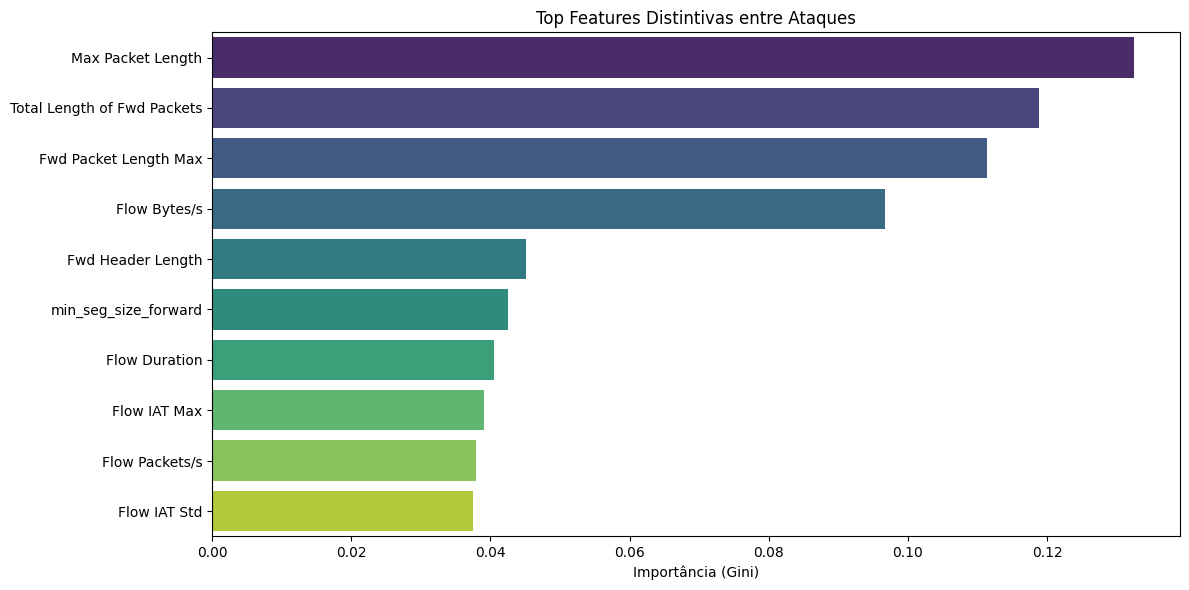

In [7]:
top_features = identificar_features_importantes(df_analise, top_n=10)

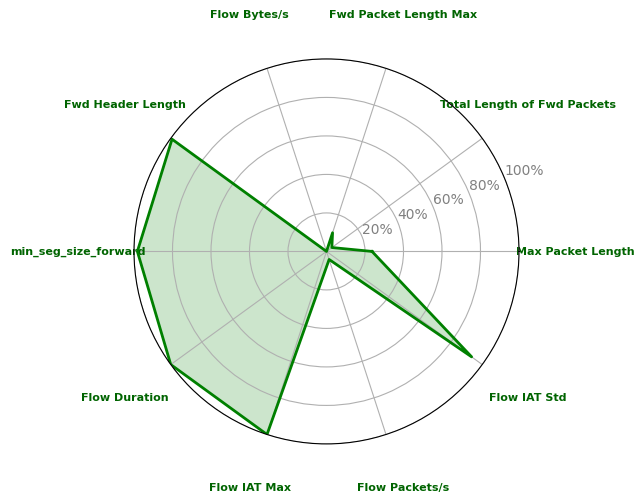

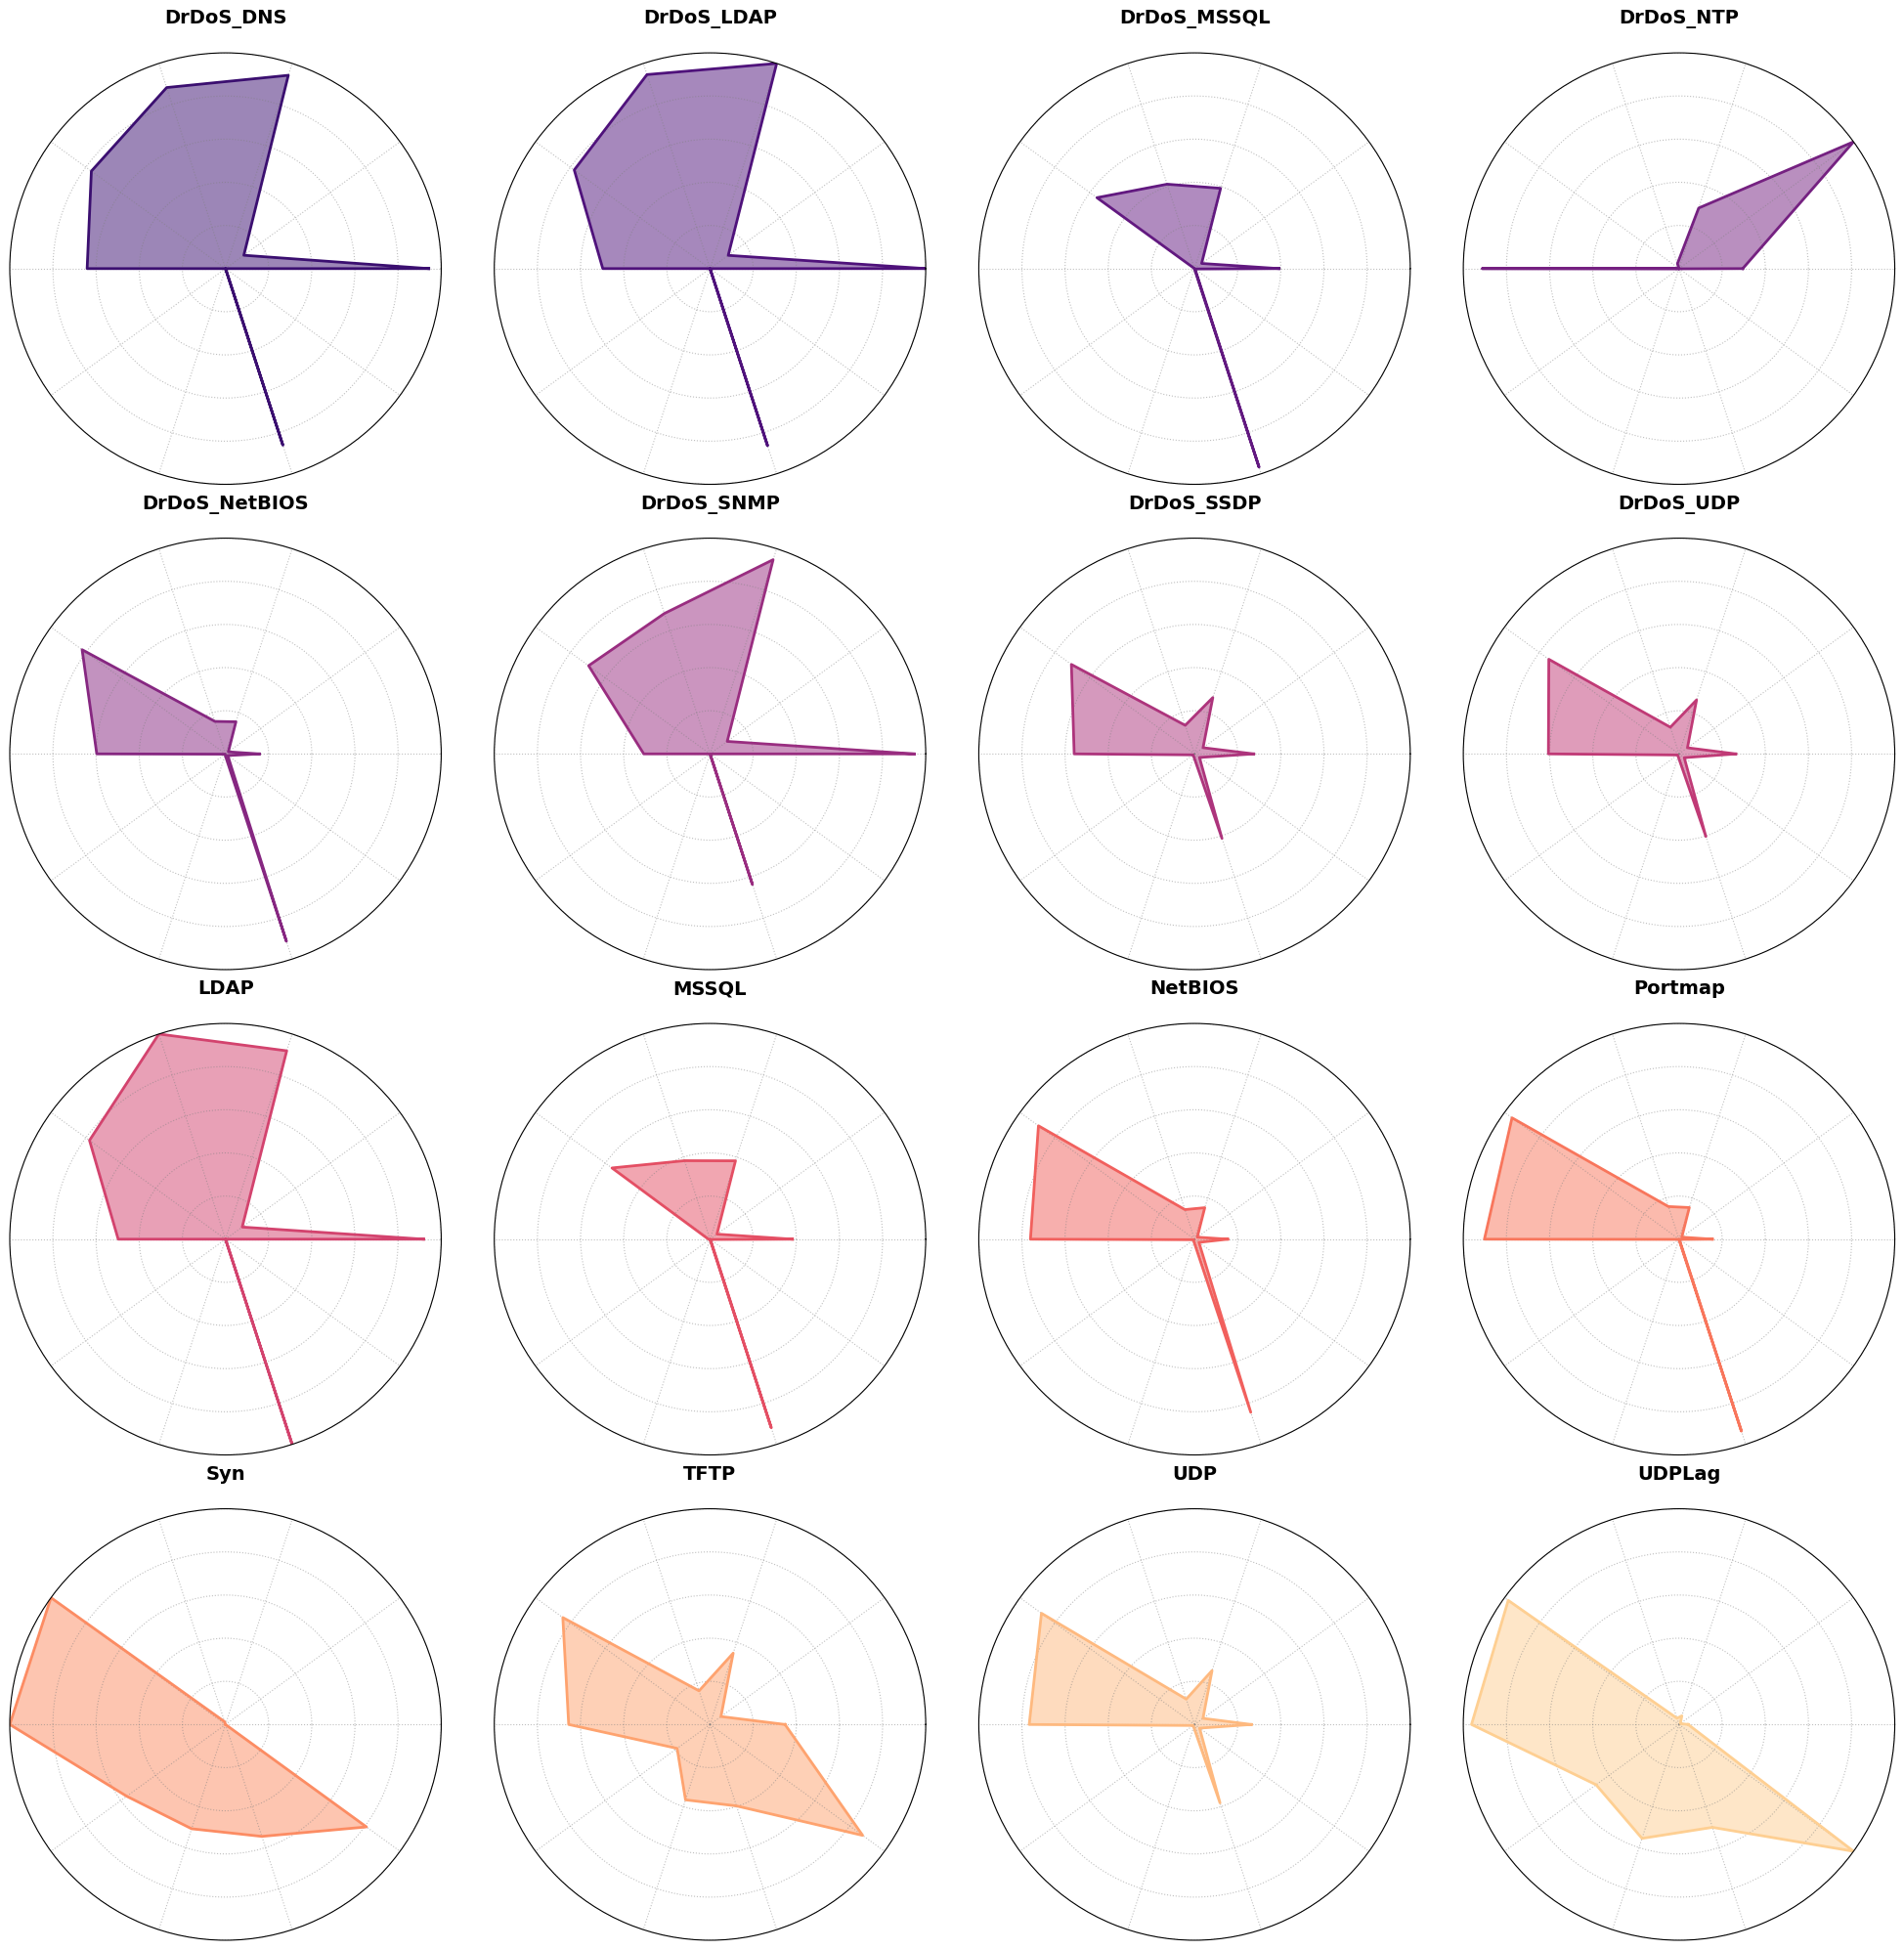

In [8]:
visualizar_radares_separados_referencia(df_analise, top_features[:10])

Clusterizando grupos com similaridade rígida > 90.0%...


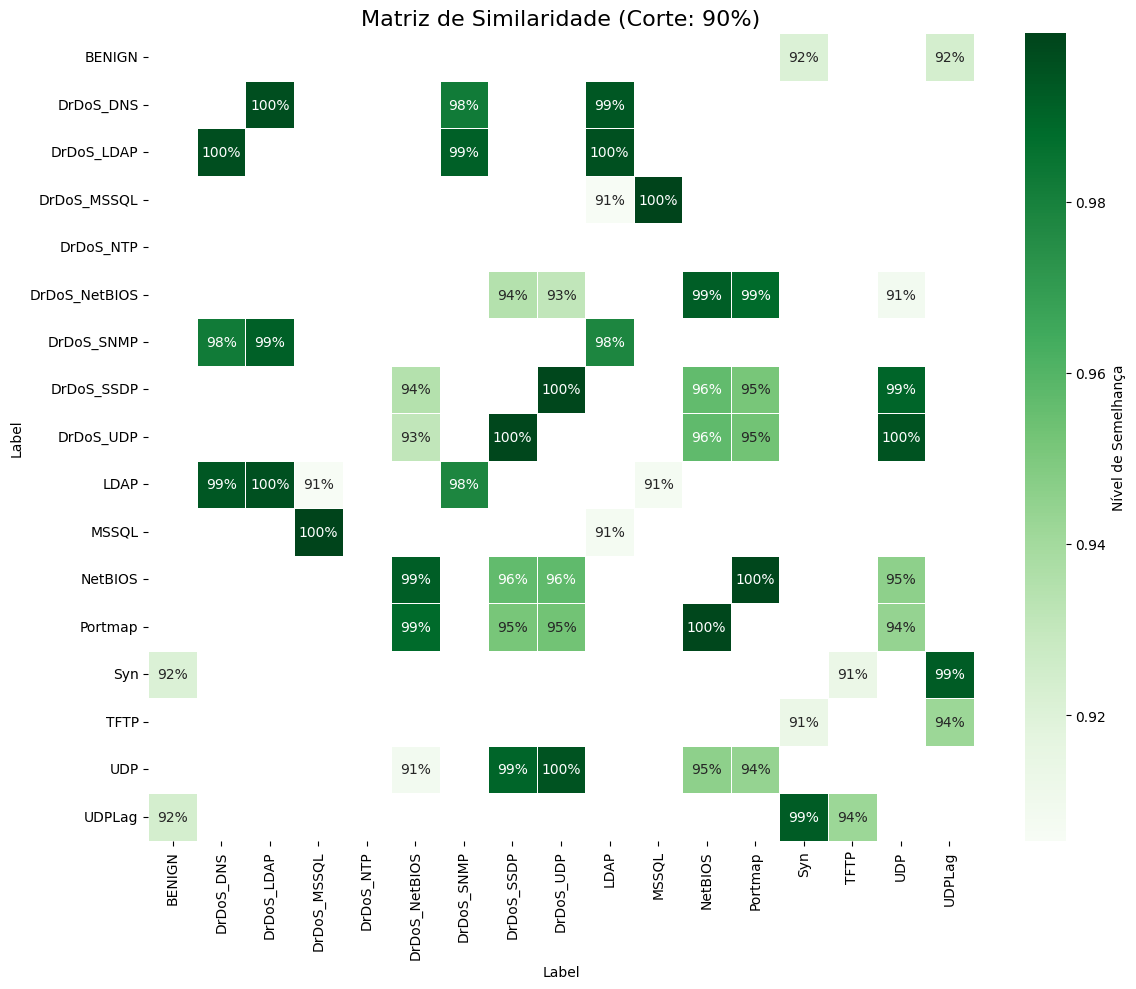

,Identificação,Membros,Qtd,Similaridade Média,Detalhe das Conexões
0,Grupo 1,"Syn, TFTP, UDPLag",3,94.9%,Syn-TFTP (91%); Syn-UDPLag (99%); TFTP-UDPLag (94%)
1,Grupo 3,"DrDoS_NetBIOS, DrDoS_SSDP, DrDoS_UDP, NetBIOS, Portmap, UDP",6,96.3%,DrDoS_NetBIOS-DrDoS_SSDP (94%); DrDoS_NetBIOS-DrDoS_UDP (93%); DrDoS_SSDP-DrDoS_UDP (100%); DrDoS_NetBIOS-NetBIOS (99%); DrDoS_SSDP-NetBIOS (96%); DrDoS_UDP-NetBIOS (96%); DrDoS_NetBIOS-Portmap (99%); DrDoS_SSDP-Portmap (95%); DrDoS_UDP-Portmap (95%); NetBIOS-Portmap (100%); DrDoS_NetBIOS-UDP (91%); DrDoS_SSDP-UDP (99%); DrDoS_UDP-UDP (100%); NetBIOS-UDP (95%); Portmap-UDP (94%)
2,Grupo 4,"DrDoS_MSSQL, MSSQL",2,100.0%,DrDoS_MSSQL-MSSQL (100%)
3,Grupo 5,"DrDoS_DNS, DrDoS_LDAP, DrDoS_SNMP, LDAP",4,99.0%,DrDoS_DNS-DrDoS_LDAP (100%); DrDoS_DNS-DrDoS_SNMP (98%); DrDoS_LDAP-DrDoS_SNMP (99%); DrDoS_DNS-LDAP (99%); DrDoS_LDAP-LDAP (100%); DrDoS_SNMP-LDAP (98%)
4,Isolado,BENIGN,1,N/A,Nenhuma (Ataque Único)
5,Isolado,DrDoS_NTP,1,N/A,Nenhuma (Ataque Único)


In [26]:
relatorio_grupos = analisar_grupos_similares(df_analise, top_features, limiar=0.90)
display(relatorio_grupos)